<a href="https://colab.research.google.com/github/Camicb/Copper-Forecasting/blob/main/Part_1_Price_Copper_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Part 1. Copper Price Forecasting**

## 1. Introduction

In Chile there are 26 mining deposits that produce 5.7 million tons of copper per year, which represents 28% of world production [[1]](https://www.elmostrador.cl/noticias/opinion/2021/03/28/importancia-del-cobre-cu-en-la-descarbonizacion-de-la-economia-mundial-y-su-impacto-en-chile/). This relative abundance of copper has made it the main export of Chile and therefore its contribution is vital to the Chilean economy. Anticipating the price of copper allows the estimation of the profitability of related projects and their viability over time.

Forecasting is the prediction on data with a time dimension. In this project, I will forecast the price of copper, with data manually extracted from the Chilean Copper Commission, [COCHILCO](https://boletin.cochilco.cl/estadisticas/grafico.asp?tipo_metal=1) from years 1999 to 2021 (today).

The data was extracted, joined, and cleaned using Microsoft Excel, and then uploaded as a [Google Sheet](https://drive.google.com/file/d/1Hyi1jYV-1RJ2dCAKlbApFT8gx0x9i0U0/view?usp=sharing). For this analysis, I will use traditional ARIMA models and the library Facebook Prophet. I will not consider other variables that have been associated with the increase or decrease of the prices; the impacts of these variables will be studied in the second part of this project.

The copper price is determined worldwide by the [London Metal Exchange](https://www.lme.com/en-GB/Metals/Non-ferrous/Copper#tabIndex=0). 
The data provided by COCHILCO have 2 variables:


*   **Fecha** : Datetime
*   **Precio Nominal Cobre Diario (¢/lb)**: the price, in cents per pound of copper



## 2. Import Required Libraries



In [1]:
# Installing required libraries
! pip install scipy -U -q
! pip install statsmodels -U -q
! pip install pystan -q
! pip install fbprophet -q
! pip install pmdarima -q
! pip install auto-ts -q
! pip install xgboost -q
! pip install delayed -q

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from auto_ts import auto_timeseries
from sklearn.metrics import mean_squared_error
import matplotlib as mpl

In [3]:
# For reproducibility
np.random.seed(2021)

## 3. Exploratory Data Analysis and Preprocessing

In [4]:
# Loading the data
price = pd.read_excel('/content/drive/MyDrive/DATASETS/Copper/precio_cobre.xlsx')

In [5]:
# Inspecting the data
price.tail()
print(' ')
price.info()
print(' ')
price.describe()

,Fecha,Precio Nominal Cobre Diario (¢/lb)
5615,2021-03-24,408.96
5616,2021-03-25,398.30
5617,2021-03-26,405.01
5618,2021-03-29,405.63
5619,2021-03-30,398.64


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5620 entries, 0 to 5619
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               5620 non-null   datetime64[ns]
 1   Precio Nominal Cobre Diario (¢/lb)  5620 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 87.9 KB
 


,Precio Nominal Cobre Diario (¢/lb)
count,5620.000000
mean,237.851087
std,109.970242
min,59.830000
25%,131.167500
50%,265.645000
75%,324.015000
max,460.310000


I will rename the variables, Fecha (Date) as 'ds', and 'Precio Nominal Cobre Diario (¢/lb) (Price) as 'y',  just for simplification in the future modeling.

In [6]:
# Redefining variables for simplification purposes
price.rename(columns={'Fecha': 'ds'}, inplace=True)
price.rename(columns={'Precio Nominal Cobre Diario (¢/lb)': 'y'}, inplace=True)

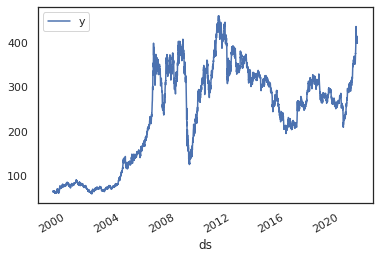

In [7]:
# Visualizing data
price.plot(x='ds',y='y')

The visualization clearly shows the crisis of 2008, and that this has a more negative impact on copper prices compared to the crisis produced by COVID-19. Therefore, for modeling I will only use data from 2011 onwards.

In [8]:
# Resampling data
price_res = price[price['ds']>='2011-01-01']
price_res.head()

,ds,y
3031,2011-01-04,442.43
3032,2011-01-05,429.14
3033,2011-01-06,435.04
3034,2011-01-07,426.33
3035,2011-01-10,425.65


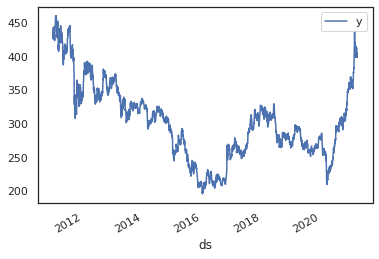

In [9]:
# Visualizing resampled data
price_res.plot(x='ds', y='y')

I will split data into training and testing datasets, considering predictions for an horizon of 60 days just to keep things simple.

In [10]:
# Spliting data and 
train = price_res[0:-60] 
test = price_res[-60:]   

# Setting indexes
train.index = train['ds']
test.index = test['ds']

In [11]:
print(train.shape)
print(test.shape)

(2529, 2)
(60, 2)


## 4. Modeling

### 4.1 ARIMA based models


[ARIMA](https://people.duke.edu/~rnau/411arim.htm), or Autoregressive Integrated Moving Average, is a very popular statistical method for time series forecasting. 

An ARIMA model can be considered as a special type of regression model. ARIMA models take into account the past values to predict the future values.

Parameter tuning for ARIMA consumes a lot of time. So for this project I will use [Auto_TimeSerie](https://github.com/AutoViML/Auto_TS), which is a python library that rapidly build predictive models based on Statsmodels ARIMA, Seasonal ARIMA, Facebook Prophet and Scikit-Learn ML. I will choose the model type "Arima", to automatically selects the best combination parameters that provides the least error, and  I will consider a business day time interval.


In [12]:
# Creating model
model = auto_timeseries(score_type='rmse', 
                        time_interval='B', 
                        seasonal_period=30,
                        model_type=['ARIMA'], 
                        verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -2.524270964992547      |
|           p-value           |      0.1096800584845049      |
|          #Lags Used         |             0.0              |
| Number of Observations Used |            2528.0            |
|     Critical Value (1%)     |      -3.432939379929173      |
|     Critical Value (5%)     |      -2.862683979868293      |
|     Critical Value (10%)    |     -2.5673789838429837      |
+-----------------------------+------------------------------+
 this series is non-stationary. Trying test again after differencing...
After differencing=1, results of Augmented Dickey-Fuller Test:
+-----------------

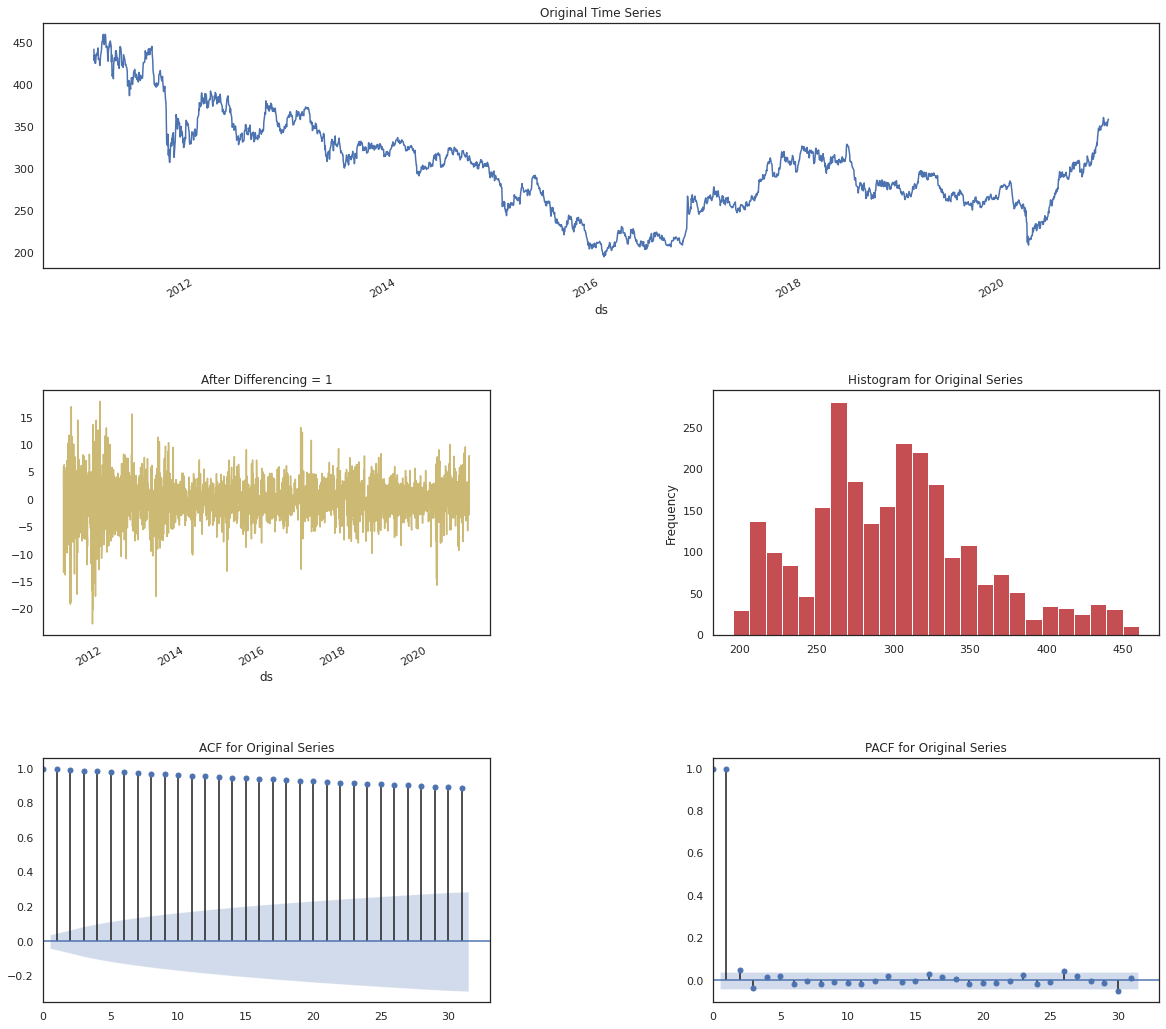

Time Interval is given as B
    Correct Time interval given as a valid Pandas date-range frequency...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 30

Fold Number: 1 --> Train Shape: 2504 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(0,1,0)*(0,0,0,30), aic = 13831.458
Static Forecasts:
    RMSE = 12.28
    Std Deviation of Actuals = 3.62
    Normalized RMSE = 338.9%

Fold Number: 2 --> Train Shape: 2509 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(0,1,0)*(0,0,0,30), aic = 13862.743
Static Forecasts:
    RMSE = 1.83
    Std Deviation of Actuals = 1.76
    Normalized RMSE = 103.9%

Fold Number: 3 --> Train 

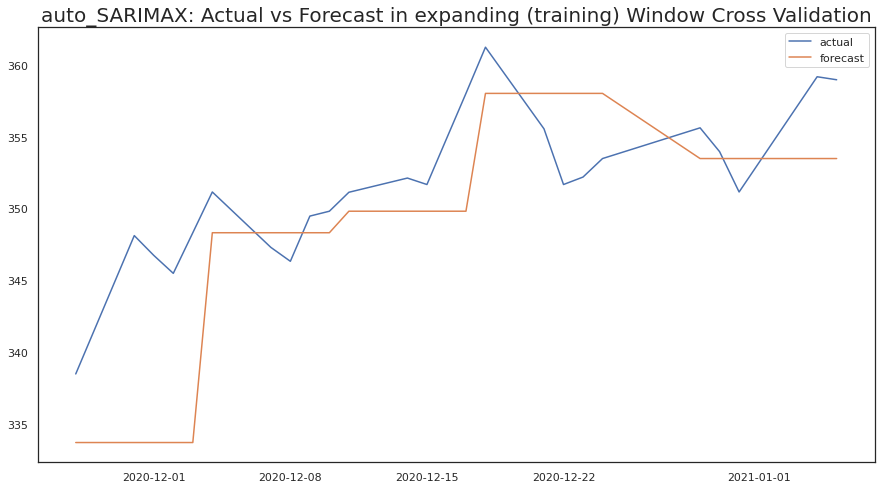

In [13]:
# Fitting model
ts_column = 'ds'
target = 'y'

model.fit( traindata=train, ts_column=ts_column, target=target)

In [14]:
# Evaluate results for validation data
model.get_leaderboard()

,name,rmse
0,auto_SARIMAX,5.437187


In [15]:
# Make sure all models have the same number of CV folds
model.get_cv_scores()

,Model,CV Scores
0,auto_SARIMAX,12.276603
1,auto_SARIMAX,1.825470
2,auto_SARIMAX,4.546291
3,auto_SARIMAX,4.720006
4,auto_SARIMAX,3.817565


In [16]:
# Predictions
future_predictions = model.predict(
    testdata=test.drop(columns=target),
    model='auto_SARIMAX')

# Set index
future_predictions.index = test.index

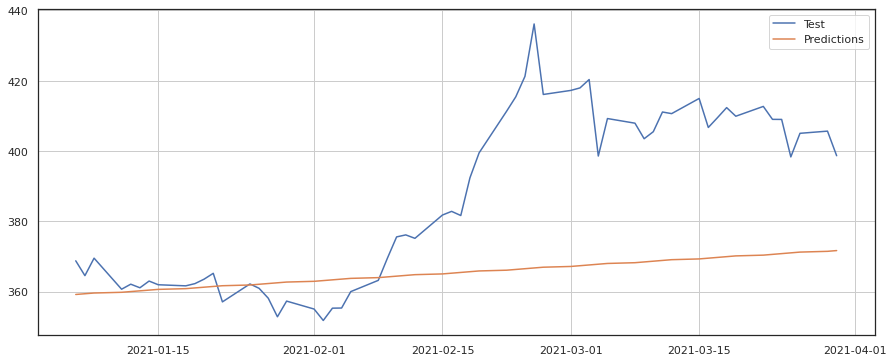

In [17]:
# Visualizing results
mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = True
plt.plot(test['y'], label='Test')
plt.plot(future_predictions['yhat'], label='Predictions')
plt.legend()

In [18]:
# Metrics
mean_squared_error(test['y'], future_predictions['yhat'])

893.2501386133806

The auto ARIMA model uses past data to understand the pattern in the time series. Using these values, as is evident from the plot, the model captures slightly the trend but could not do it with the seasonal part; therefore, the predictions are not close to the real values and the error is significant.

###4.2 Facebook Prophet

Facebook Prophet is an open source software released by Facebook’s Core Data Science team. 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It requires two variables : a column with the datetimes named 'ds', and column with the values named 'y'.

I will try Facebook Prophet without using Auto_TimeSerie for this part.  Auto_TimeSerie is a good library for experimentation but tends to collapse with bigger data, so it can not be the only tool for forecasting.




In [19]:
# Creating model 
m= Prophet()
m.fit(train)

In [20]:
# Creting the range for predictions
future_price = test.drop(['y'], axis=1)
future_price.tail()

,ds
ds,
2021-03-24,2021-03-24
2021-03-25,2021-03-25
2021-03-26,2021-03-26
2021-03-29,2021-03-29
2021-03-30,2021-03-30


In [21]:
# Making predictions
forecast = m.predict(future_price)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2021-03-24,292.658781,270.230582,314.768738
56,2021-03-25,292.546407,269.905887,314.811960
57,2021-03-26,292.754969,272.143796,315.608500
58,2021-03-29,292.396370,268.444783,316.002434
59,2021-03-30,292.683439,270.179948,315.835871


The model provided the values:

**yhat**: the forecasted value (the predicted values for y)

**yhat_lower**: the lower bound of the forecast

**yhat_upper**: the upper bound of the forecast

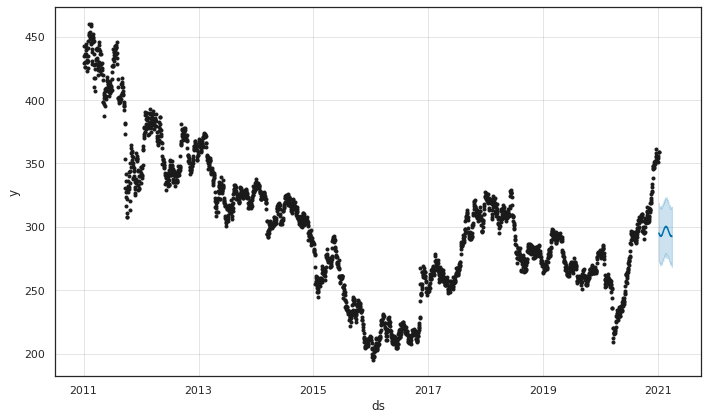

In [22]:
# Plot the forecast
fig1 = m.plot(forecast, uncertainty=True)


Prophet plots the observed values of time series (black dots), the forecasted values (blue lines) and the uncertainty intervals of the forecasts ( blue shaded region).

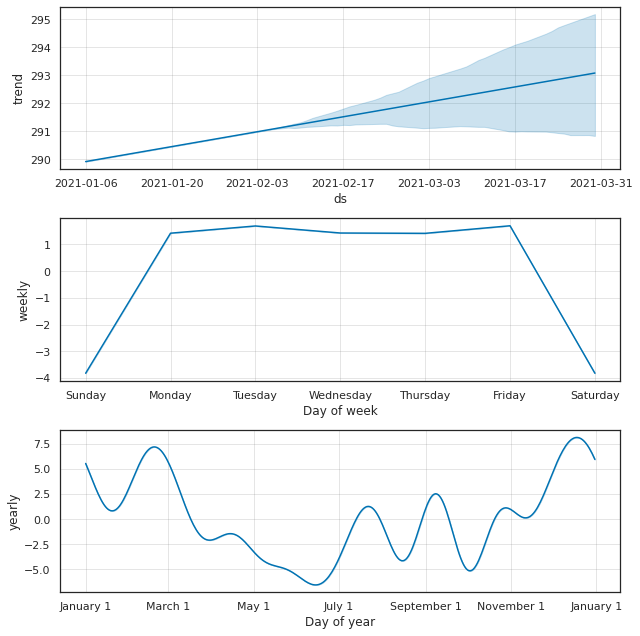

In [23]:
# Plot forecast components
fig2 = m.plot_components(forecast)

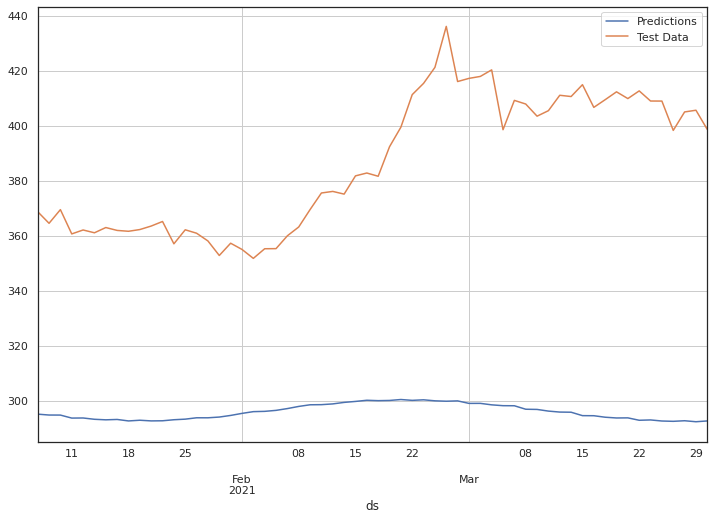

In [24]:
# Plot test data and predictions
ax_price=forecast.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='Test Data',ax=ax_price)

In [26]:
# Metrics
y_test = test['y']
y_predict = forecast['yhat']
mean_squared_error(y_test, y_predict)

8724.997734163877

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time-series datasets but fails enormously in this case, where the error is even worse compared with the ARIMA model.


## 5. Conclusion
As it turns out, copper prices do not have a particular trend or seasonality. They highly depend on the international market situation and the values of other commodities. Hence forecasting techniques like ARIMA, SARIMAX, and Prophet would not show good results for this problem, where only the dates and the prices constitute the data.

##6. Bibliography

*  https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

*  https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

*  https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA

*  https://facebook.github.io/prophet/docs/quick_start.html#python-api

*  https://sailajakarra.medium.com/facebook-prophet-for-time-series-cf26be1be274

